## BFGS + interpolação quadrática

In [1]:
import sympy as sy
import numpy as np
from sympy.plotting.plot import plot3d
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

(1 - x_1)**2 + (1 - x_2)**2 + 0.5*(-x_1**2 + 2*x_2)**2

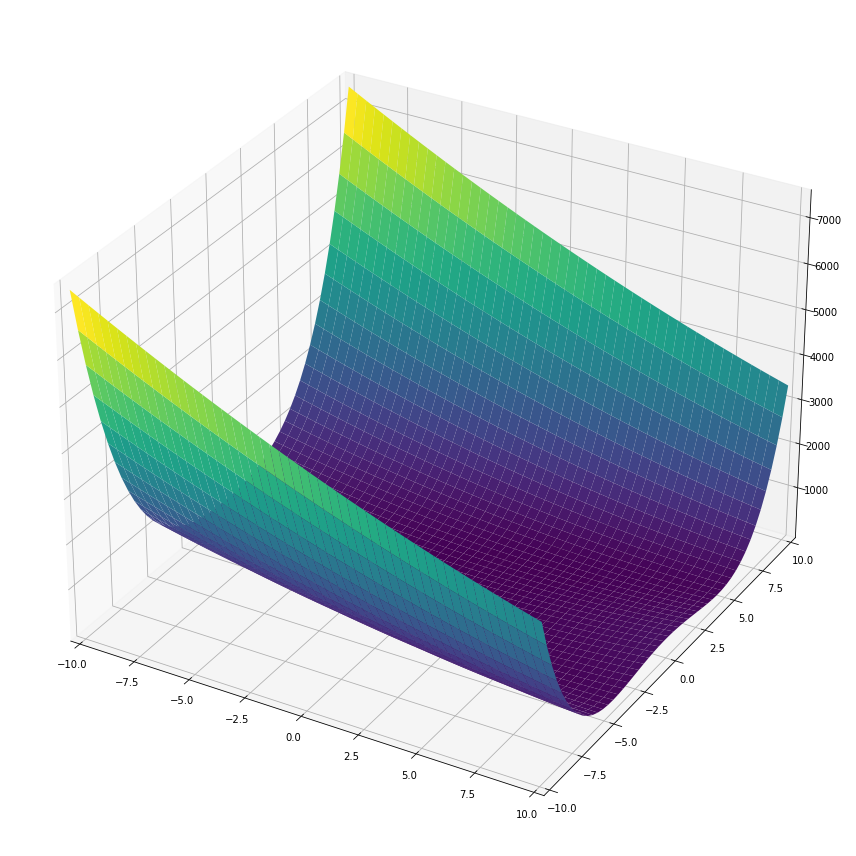

In [2]:
# Função:
x1, x2 = sy.symbols('x_1 x_2')
fx = (1 - x1)**2 + (1 - x2)**2 + 0.5 * (2 * x2 - x1**2)**2
fx
plt.rc('figure', figsize=(12, 12))
plot3d(fx)

In [3]:
# Função para interpolação quadrática para o α:
def interp(x1, x2, d1, d2):
    #faa = -9e9 # Valor inicial para f(α) para garantir pelo menos duas iterações
    j = 0      # Contador
    
    # Definição de f(α) com base nos valores atuais de x e d:
    alpha = sy.symbols(r'\alpha')
    fa = (1 - (x1 + alpha * d1))**2 + (1 - (x2 + alpha * d2))**2 + 0.5 * (2 * (x2 + alpha * d2) - (x1 + alpha * d1)**2)**2
    fa = sy.Lambda(alpha, fa)
    #sy.plot(fa(alpha))
    
    #### Passos 1 e 2 (localização do intervalo de incerteza e cálculo do αi):
    alphal = 0         # Limite inferior inicial de alpha
    alphau = 2 * delta # Limite superior
    alphai = delta     # Ponto intermediário
    
    # Início do processo iterativo:
    while True:
        j += 1
        
        #### Passo 3 (cálculo dos coeficientes a e do α_):
        # Avaliação de f(α) nos três pontos:
        fal = fa(alphal)
        fau = fa(alphau)
        fai = fa(alphai)
        
        # Interpolação por polinômio de segundo grau (fórmula mostrada no Arora):
        a2 = 1/(alphau - alphai) * ((fau - fal)/(alphau - alphal) - (fai - fal)/(alphai - alphal))
        a1 = (fai - fal)/(alphai - alphal) - a2 * (alphal + alphai)
        a0 = fal - a1 * alphal - a2 * alphal**2
        
        # Condição necessária para minimização do polinômio:
        alpha_ = -a1/(2 * a2)
        
        # Condição suficiente:
        #if a2 > 0:
        #    pass

        # Avaliação de f(α) em α_:
        fa_ = fa(alpha_)

        #### Passos 4 e 5 (ajuste dos limites do intervalo de incerteza):
        if alphai < alpha_:
            if fai < fa_:
                alphau = alpha_
            else:
                alphal = alphai
                alphai = alpha_
        else:
            if fai < fa_:
                alphal = alpha_
            else:
                alphau = alphai
                alphai = alpha_

        # Verificação:
        intervalo = alphau - alphal
        #print(j, intervalo)
        
        # Se o intervalo de incerteza for suficientemente pequeno:
        if abs(intervalo) < tol_alpha:
            alpha = float((alphau + alphal)/2) # Retorna o valor médio de α no intervalo
            break
    
    return alpha, j

**Procedimento de otimização:**

xx = np.linspace(-2, 2, 21)
yy = np.linspace(-2, 2, 21)

for m in xx:
    for n in yy:
        xi = [m, n] # Ponto de partida
        try:
            #### Passo 1:
            tol = 1e-2        # Tolerância para a norma do gradiente
            tol_alpha = 1e-5  # Tolerância para o intervalo de incerteza do alpha (interpolação)
            delta = 0.5       # Parâmetro do algoritmo para otimização do alpha (interpolação)
            alpha = 5e-2      # Para teste do programa com passo fixo
            imax = 2e2        # Número máximo de iterações

            x = np.matrix(xi) # Matriz numpy com os valores iniciais de x
            H = np.eye(2)     # Estimativa inicial para H é a identidade
            norm = 1e9        # Norma alta para garantir pelo menos duas iterações do while
            i = 0             # Contador de iterações
            aval = 0          # Contador de avaliações de funções
            xh = [xi]         # Para registrar o histórico de x
            alphah = [delta]  # Para registrar o histórico de alpha

            # Início do processo iterativo:
            while True:
                i += 1
                #print(i)
                if i > imax:
                    print(f'Número máximo de iterações excedido no ponto inicial {xi}!')
                    print(f'Quantidade de avaliações de função: {aval}\n')
                    erro = 1
                    break

                #### Passo 2 (cálculo da norma do gradiente):
                gx1 = -2 * x[0, 0] * (-x[0, 0]**2 + 2 * x[0, 1]) + 2 * x[0, 0] - 2 # Derivada parcial em relação a x1
                gx2 = -2 * x[0, 0]**2 + 6 * x[0, 1] - 2                            # Derivada parcial em relação a x1
                grad = np.matrix([gx1, gx2]).T
                norm = np.linalg.norm(grad)
                grad = grad/norm

                #### Passo 3 (cálculo da direção de descida):
                d = np.linalg.inv(H) * (-grad)

                #### Passo 4 (cálculo do alpha por interpolação):
                x1, x2 = x[0, 0], x[0, 1]
                d1, d2 = d[0, 0], d[1, 0]
                alpha, j = interp(x1, x2, d1, d2)
                aval += 4 * j
                alphah.append(alpha)

                #### Passo 5 (atualização do vetor x):
                x = x + alpha * d.T
                xh.append([x[0, 0], x[0, 1]])

                #### Passo 6 (atualização da Hessiana):
                gx1 = -2 * x[0, 0] * (-x[0, 0]**2 + 2 * x[0, 1]) + 2 * x[0, 0] - 2 # Derivada parcial em relação a x1
                gx2 = -2 * x[0, 0]**2 + 6 * x[0, 1] - 2                            # Derivada parcial em relação a x1
                grad_next = np.matrix([gx1, gx2]).T                                # Gradiente de k+1
                grad_next = grad_next/(np.linalg.norm(grad_next))
                y = grad_next - grad
                s = alpha * d.T

                D = (y * y.T) / (y * s)
                E = (grad * grad.T) / (grad * d.T)
                H = H + D + E

                # Verificação:
                if norm < tol:
                    f = (1 - x[0, 0])**2 + (1 - x[0, 1])**2 + 0.5 * (2 * x[0, 1] - x[0, 0]**2)**2
                    print(f'Ponto inicial {xi}:')
                    print(f'Ótimo encontrado com {i} iterações: x1 = {round(x[0, 0], 4)}, x2 = {round(x[0, 1], 4)}')
                    print(f'Quantidade de avaliações de função: {aval}')
                    print(f'Valor de f(x1, x2) no ponto ótimo: {round(f, 6)}\n')
                    erro = 0
                    break
        
        except:
            print(f'Erro no ponto {xi}\n')

(1 - x_1)**2 + (1 - x_2)**2 + 0.5*(-x_1**2 + 2*x_2)**2

n = 2
ε = 0.01
ρ = 1e-05
xi = [-0.15, 0]
Ótimo encontrado com 17 iterações: x* = [1.2119, 0.8219]
Quantidade de avaliações de função: 744
Valor de f(x1, x2, x3) no ponto ótimo: 0.091951
Valor da norma do gradiente: 0.005203


<a list of 14 text.Text objects>

Text(0.5, 1.0, 'Otimização da função $f(x_1, x_2) = \\left(1 - x_{1}\\right)^{2} + \\left(1 - x_{2}\\right)^{2}$$+ 0.5 \\left(- x_{1}^{2} + 2 x_{2}\\right)^{2}$')

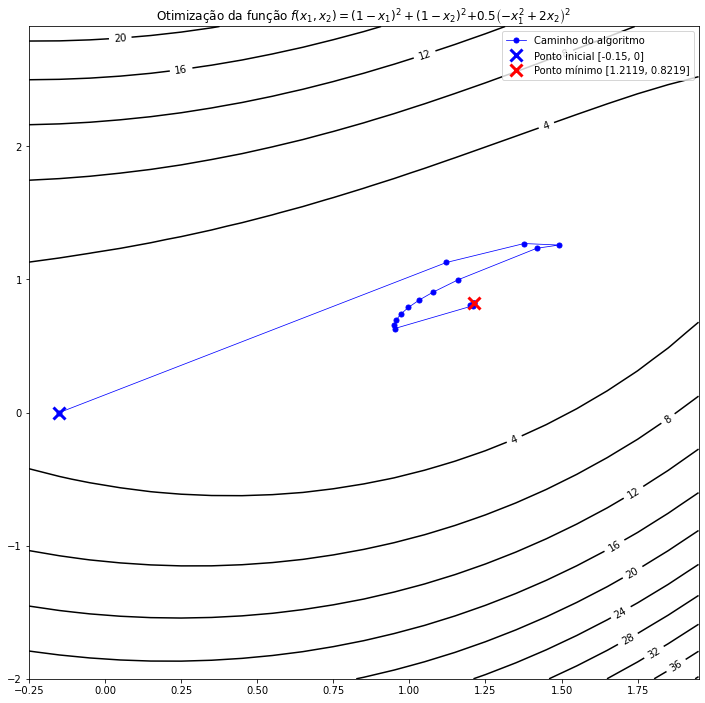

In [4]:
#### Passo 1:
xi = [-0.15, 0]  # Ponto de partida
tol = 1e-2        # Tolerância para a norma do gradiente
tol_alpha = 1e-5  # Tolerância para o intervalo de incerteza do alpha (interpolação)
delta = 0.5       # Parâmetro do algoritmo para otimização do alpha (interpolação)
alpha = 5e-2      # Para teste do programa com passo fixo
imax = 1e3        # Número máximo de iterações

x = np.matrix(xi) # Matriz numpy com os valores iniciais de x
H = np.eye(2)     # Estimativa inicial para H é a identidade
norm = 1e9        # Norma alta para garantir pelo menos duas iterações do while
i = 0             # Contador de iterações
aval = 0          # Contador de avaliações de funções
xh = [xi]         # Para registrar o histórico de x
alphah = [delta]  # Para registrar o histórico de alpha

# Início do processo iterativo:
while True:
    i += 1
    #print(i)
    if i > imax:
        print('Número máximo de iterações excedido!')
        print(f'Quantidade de avaliações de função: {aval}')
        erro = 1
        break
    
    #### Passo 2 (cálculo da norma do gradiente):
    gx1 = -2 * x[0, 0] * (-x[0, 0]**2 + 2 * x[0, 1]) + 2 * x[0, 0] - 2 # Derivada parcial em relação a x1
    gx2 = -2 * x[0, 0]**2 + 6 * x[0, 1] - 2                            # Derivada parcial em relação a x1
    grad = np.matrix([gx1, gx2]).T
    norm = np.linalg.norm(grad)
    grad = grad/norm # Normalizar o gradiente
    
    #### Passo 3 (cálculo da direção de descida):
    d = np.linalg.inv(H) * (-grad)

    #### Passo 4 (cálculo do alpha por interpolação):
    x1, x2 = x[0, 0], x[0, 1]
    d1, d2 = d[0, 0], d[1, 0]
    alpha, j = interp(x1, x2, d1, d2)
    aval += 4 * j
    alphah.append(alpha)
    
    #### Passo 5 (atualização do vetor x):
    x = x + alpha * d.T
    xh.append([x[0, 0], x[0, 1]])

    #### Passo 6 (atualização da Hessiana):
    gx1 = -2 * x[0, 0] * (-x[0, 0]**2 + 2 * x[0, 1]) + 2 * x[0, 0] - 2 # Derivada parcial em relação a x1
    gx2 = -2 * x[0, 0]**2 + 6 * x[0, 1] - 2                            # Derivada parcial em relação a x1
    grad_next = np.matrix([gx1, gx2]).T                                # Gradiente de k+1
    grad_next = grad_next/(np.linalg.norm(grad_next))
    y = grad_next - grad
    s = alpha * d.T

    D = (y * y.T) / (y * s)
    E = (grad * grad.T) / (grad * d.T)
    H = H + D + E
    
    # Verificação:
    if norm < tol:
        f = (1 - x[0, 0])**2 + (1 - x[0, 1])**2 + 0.5 * (2 * x[0, 1] - x[0, 0]**2)**2
        xs = [round(x[0, 0], 4), round(x[0, 1], 4)]
        fx
        print('n = 2')
        print(f'ε = {tol}')
        print(f'ρ = {tol_alpha}')
        print(f'xi = {xi}')
        print(f'Ótimo encontrado com {i} iterações: x* = {xs}')
        print(f'Quantidade de avaliações de função: {aval}')
        print(f'Valor de f(x1, x2, x3) no ponto ótimo: {round(f, 6)}')
        print(f'Valor da norma do gradiente: {round(norm, 6)}')
        erro = 0
        break

#### Plot:
d = 0.1
x = np.arange(-0.25, 2, d)
y = np.arange(-2, 3, d)
x1, x2 = np.meshgrid(x, y)

f = (1 - x1)**2 + (1 - x2)**2 + 0.5 * (2 * x2 - x1**2)**2

fig, ax = plt.subplots()
title = (r'Otimização da função $f(x_1, x_2) = \left(1 - x_{1}\right)^{2} + \left(1 - x_{2}\right)^{2}$'
         r'$+ 0.5 \left(- x_{1}^{2} + 2 x_{2}\right)^{2}$')
CS = ax.contour(x, y, f, 10, colors='k')
ax.clabel(CS, inline=0.5, fontsize=10)
ax.set_title(title)

if erro == 0:
    string = f'Ponto mínimo [{round(xh[-1][0], 4)}, {round(xh[-1][1], 4)}]'
else:
    string = f'Último valor encontrado [{round(xh[-1][0], 4)}, {round(xh[-1][1], 4)}]'
    
caminho_x = [xh[i][0] for i in range(len(xh))]
caminho_y = [xh[i][1] for i in range(len(xh))]
plt.plot(caminho_x, caminho_y, marker='.', lw=0.75, ms=10, label='Caminho do algoritmo', c='blue')
plt.plot(xi[0], xi[1], marker='x', ls='', ms=12, label=f'Ponto inicial {xi}', c='blue', mew=3)
plt.plot(xh[-1][0], xh[-1][1], marker='x', ls='', ms=12, label=string, c='red', mew=3)
plt.legend()

plt.show()

**Resultados anteriores:**

Com ponto inicial [0, 0] e outros parâmetros para o alpha:
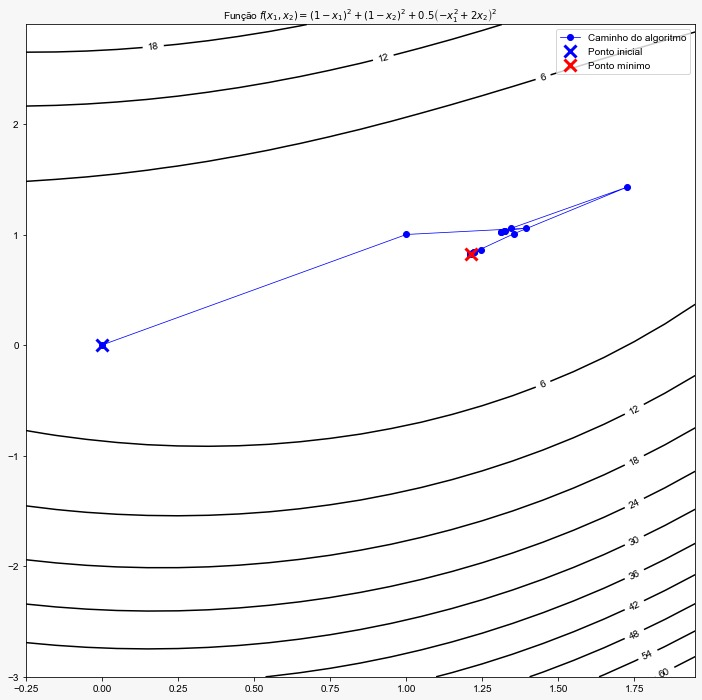

Com passo fixo:

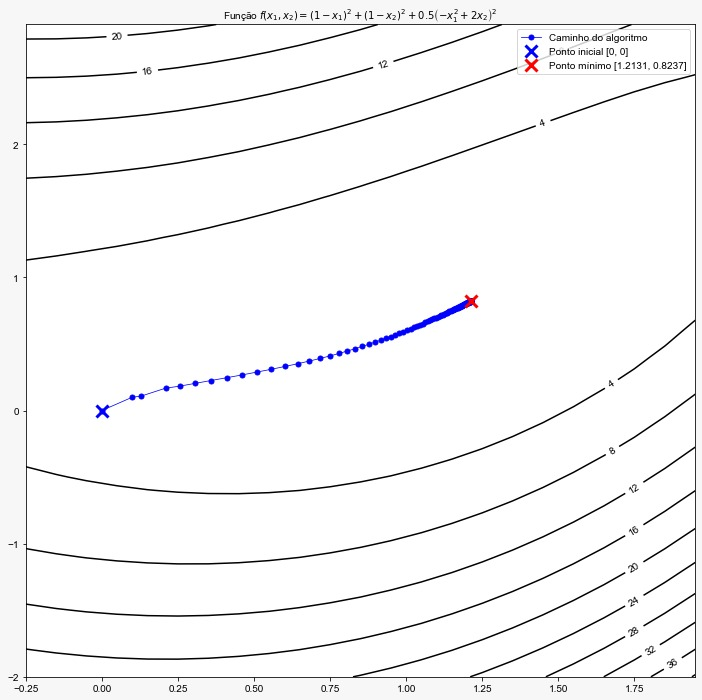